In [1]:
import pandas as pd 
import numpy as np 
import h5py, sys, traceback, os, tqdm, time
from script.utilize import pdgid, purity_classifier
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import ticker
from os import makedirs
from matplotlib import rcParams

In [2]:
# Set data prefix
PREFIX = 'PPTT_FHD_CR_COMPARE/parsed_file/'

# Load truth matching data and truth matching data
with np.load(os.path.join(PREFIX, "truth_matching/event_record_cr_qcd.npz"), allow_pickle=True) as file:
    jet_pt = file['jet_pt']
    jet_eta = file['jet_eta']
    jet_phi = file['jet_phi']
    jet_mass = file['jet_mass']
    parton_jet_index = file['parton_jet_index']    
    N_match_top_in_event = file['N_match_top_in_event']    

# Load general chi2 data and truth matching data
with np.load(os.path.join(PREFIX, "chi2/event_record_cr_qcd_chi2.npz"), allow_pickle=True) as file:
    parton_jet_index_chi2 = file['parton_jet_index']    
    N_match_top_in_event_chi2 = file['N_match_top_in_event']       

# Load Top mass based chi2 data
with np.load(os.path.join(PREFIX, "chi2_mtop/event_record_cr_qcd_chi2_mtop.npz"), allow_pickle=True) as file:
    parton_jet_index_chi2_mtop = file['parton_jet_index']    
    N_match_top_in_event_chi2_mtop = file['N_match_top_in_event']       

In [3]:
# Find both match and partial match event 
chi2_n_match_2_idx = np.where(N_match_top_in_event == 2)
chi2_n_match_1_idx = np.where(N_match_top_in_event == 1)

# Rename variable
general_chi2_predict = parton_jet_index_chi2
mtop_chi2_predict = parton_jet_index_chi2_mtop
truth_matching = parton_jet_index

# Filter both match and partial match event 
twin_top_general_chi2_predict = general_chi2_predict[chi2_n_match_2_idx]
single_top_general_chi2_predict = general_chi2_predict[chi2_n_match_1_idx]

twin_top_mtop_chi2_predict = mtop_chi2_predict[chi2_n_match_2_idx]
single_top_mtop_chi2_predict = mtop_chi2_predict[chi2_n_match_1_idx]

twin_top_truth_matching = truth_matching[chi2_n_match_2_idx]
single_top_truth_matching = truth_matching[chi2_n_match_1_idx] 

print(f'{len(truth_matching)            = }, {len(mtop_chi2_predict)            = }, {len(general_chi2_predict)            = }')
print(f'{len(twin_top_truth_matching)   = }, {len(twin_top_mtop_chi2_predict)   = }, {len(twin_top_general_chi2_predict)   = }')
print(f'{len(single_top_truth_matching) = }, {len(single_top_mtop_chi2_predict) = }, {len(single_top_general_chi2_predict) = }')


len(truth_matching)            = 9498, len(mtop_chi2_predict)            = 9498, len(general_chi2_predict)            = 9498
len(twin_top_truth_matching)   = 3057, len(twin_top_mtop_chi2_predict)   = 3057, len(twin_top_general_chi2_predict)   = 3057
len(single_top_truth_matching) = 6441, len(single_top_mtop_chi2_predict) = 6441, len(single_top_general_chi2_predict) = 6441


In [4]:
# Define `compute` function for computing purity 
def compute(target, source):
    """
    Classify the candidates is swapped or not.(i.e. [[1,2,3], [4,7,8]] -> [[4,7,8], [1,2,3]])
    Then throw the prediction and truth matching data to `purity_classifier` function.
    """
    MODEL = 'ttbar'
    correct_left = np.full(len(target), 99999)
    correct_right = np.full(len(target), 99999)
    case = np.zeros(len(target))

    for i in tqdm.trange(len(target)):

        left_target = target[i][:3]
        right_target = target[i][3:]

        left_src = source[i][:3]    
        right_src = source[i][3:]  

        if np.sum(left_src == 'Nan' ) >0:
            correct_left[i] = 4       
        if np.sum(right_src == 'Nan' ) >0:
            correct_right[i] = 4

        if correct_left[i] != 4 and correct_right[i] != 4:
            correct_left[i], correct_right[i] = purity_classifier(target[i], source[i], "pair", MODEL)
        elif correct_left[i] != 4 and correct_right[i] == 4:
            correct_left[i] = purity_classifier(target[i], source[i], "left", MODEL)
        elif correct_left[i] == 4 and correct_right[i] != 4:
            correct_right[i] = purity_classifier(target[i], source[i], "right", MODEL)
        else:
            pass

        if correct_left[i] == 1 and correct_right[i] == 1:
            case[i] = 1
        elif correct_left[i] != 1 and correct_right[i] == 1 and correct_left[i] != 4 and correct_right[i] != 4:
            case[i] = 2
        elif correct_left[i] == 1 and correct_right[i] != 1 and correct_left[i] != 4 and correct_right[i] != 4:
            case[i] = 2
        elif  correct_left[i] != 1 and  correct_right[i] != 1 and correct_left[i] != 4 and correct_right[i] != 4:
            case[i] = 3
        elif correct_left[i] == 4 or  correct_right[i] == 4:
            case[i] = 4
        
    return case, correct_right, correct_left

In [5]:
# Compute purity for all case(un-filtered, both match, partial match) without limiting number of jet.
general_chi2_case, general_chi2_correct_right, general_chi2_correct_left = compute(general_chi2_predict, truth_matching)
general_chi2_cas_2, general_chi2_correct_right_2, general_chi2_correct_left_2 = compute(twin_top_general_chi2_predict, twin_top_truth_matching)
general_chi2_case_1, general_chi2_correct_right_1, general_chi2_correct_left_1 = compute(single_top_general_chi2_predict, single_top_truth_matching)

mtop_chi2_case, mtop_chi2_correct_right, mtop_chi2_correct_left = compute(mtop_chi2_predict, truth_matching)
mtop_chi2_cas_2, mtop_chi2_correct_right_2, mtop_chi2_correct_left_2 = compute(twin_top_mtop_chi2_predict, twin_top_truth_matching)
mtop_chi2_case_1, mtop_chi2_correct_right_1, mtop_chi2_correct_left_1 = compute(single_top_mtop_chi2_predict, single_top_truth_matching)

100%|██████████| 6441/6441 [00:00<00:00, 57273.99it/s]


In [6]:
print(f'No filterd event purity and top purity.')

general_chi2_event_purity = np.sum(general_chi2_case==1)/( np.sum(general_chi2_case==1) + np.sum(general_chi2_case==2) + np.sum(general_chi2_case==3))
general_chi2_two_top_purity = ( np.sum(general_chi2_correct_right_2 ==1) + np.sum(general_chi2_correct_left_2==1)  )/( np.sum(general_chi2_correct_right_2 ==1) + np.sum(general_chi2_correct_left_2==1) + np.sum(general_chi2_correct_right_2 ==0) + np.sum(general_chi2_correct_left_2==0) )
general_chi2_single_top_purity = ( np.sum(general_chi2_correct_right_1 == 1) + np.sum(general_chi2_correct_left_1 == 1)  )/(  len(general_chi2_correct_right_1) )

print(f'Event putiry (no filter, general chi2)                              : {general_chi2_event_purity:.3f}')
print(f'Two top putiry (both match, general chi2)                           : {general_chi2_two_top_purity:.3f}')
print(f'Single top putiry (partial match, general chi2)                     : {general_chi2_single_top_purity:.3f}')

print("-"*80)

mtop_chi2_event_purity = np.sum(mtop_chi2_case==1)/( np.sum(mtop_chi2_case==1) + np.sum(mtop_chi2_case==2) + np.sum(mtop_chi2_case==3))
mtop_chi2_two_top_purity = ( np.sum(mtop_chi2_correct_right_2 ==1) + np.sum(mtop_chi2_correct_left_2==1)  )/( np.sum(mtop_chi2_correct_right_2 ==1) + np.sum(mtop_chi2_correct_left_2==1) + np.sum(mtop_chi2_correct_right_2 ==0) + np.sum(mtop_chi2_correct_left_2==0) )
mtop_chi2_single_top_purity = ( np.sum(mtop_chi2_correct_right_1==1) + np.sum(mtop_chi2_correct_left_1==1)  )/( len(mtop_chi2_correct_right_1) )
print(f'Event putiry (no filter, top mass based chi2)                       : {mtop_chi2_event_purity:.3f}')
print(f'Two top putiry (both matched, top mass based chi2)                  : {mtop_chi2_two_top_purity:.3f}')
print(f'Single top putiry (partial matched, top mass based chi2)            : {mtop_chi2_single_top_purity:.3f}')

No filterd event purity and top purity.
Event putiry (no filter, general chi2)                              : 0.359
Two top putiry (both match, general chi2)                           : 0.456
Single top putiry (partial match, general chi2)                     : 0.230
--------------------------------------------------------------------------------
Event putiry (no filter, top mass based chi2)                       : 0.415
Two top putiry (both matched, top mass based chi2)                  : 0.521
Single top putiry (partial matched, top mass based chi2)            : 0.303


In [7]:
def invariant_mass(idx, pt, eta, phi, mass):
    pt = np.array(pt)
    eta = np.array(eta)
    phi = np.array(phi)
    mass = np.array(mass)
    idx = idx.astype('int64')
    # print(f'{idx = },\n {pt = },\n {eta = },\n {phi = },\n {mass = }')
    px = pt[idx]*np.cos(phi[idx])
    py = pt[idx]*np.sin(phi[idx])
    pz = pt[idx]*np.sinh(eta[idx])
    e = np.sqrt( px**2 + py**2 + pz**2 + mass[idx]**2)
    # print(f'{px = },\n {py = },\n {pz = },\n {e = }')
    return np.sqrt((e.sum()**2) - (px.sum()**2) - (py.sum()**2) - (pz.sum()**2))

# Compute top invariant mass 
general_correct_right_top_inv = np.array([invariant_mass(parton_jet_index_chi2[i][3:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_right)) if general_chi2_correct_right[i] == 1])
general_correct_left_top_inv = np.array([invariant_mass(parton_jet_index_chi2[i][:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_left)) if general_chi2_correct_left[i] == 1])
general_correct_top_inv = np.concatenate((general_correct_right_top_inv, general_correct_left_top_inv))

general_incorrect_right_top_inv = np.array([invariant_mass(parton_jet_index_chi2[i][3:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_right)) if general_chi2_correct_right[i] == 0])
general_incorrect_left_top_inv = np.array([invariant_mass(parton_jet_index_chi2[i][:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_left)) if general_chi2_correct_left[i] == 0])
general_incorrect_top_inv = np.concatenate((general_incorrect_right_top_inv, general_incorrect_left_top_inv))

general_unmatch_right_top_inv = np.array([invariant_mass(parton_jet_index_chi2[i][3:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_right)) if general_chi2_correct_right[i] == 4])
general_unmatch_left_top_inv = np.array([invariant_mass(parton_jet_index_chi2[i][:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_left)) if general_chi2_correct_left[i] == 4])
general_unmatch_top_inv = np.concatenate((general_unmatch_right_top_inv, general_unmatch_left_top_inv))

mtop_correct_right_top_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][3:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_right)) if mtop_chi2_correct_right[i] == 1])
mtop_correct_left_top_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_left)) if mtop_chi2_correct_left[i] == 1])
mtop_correct_top_inv = np.concatenate((mtop_correct_right_top_inv, mtop_correct_left_top_inv))

mtop_incorrect_right_top_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][3:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_right)) if mtop_chi2_correct_right[i] == 0])
mtop_incorrect_left_top_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_left)) if mtop_chi2_correct_left[i] == 0])
mtop_incorrect_top_inv = np.concatenate((mtop_incorrect_right_top_inv, mtop_incorrect_left_top_inv))

mtop_unmatch_right_top_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][3:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_right)) if mtop_chi2_correct_right[i] == 4])
mtop_unmatch_left_top_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_left)) if mtop_chi2_correct_left[i] == 4])
mtop_unmatch_top_inv = np.concatenate((mtop_unmatch_right_top_inv, mtop_unmatch_left_top_inv))


In [8]:
# Compute W boson invariant mass 
general_correct_right_W_inv = np.array([invariant_mass(parton_jet_index_chi2[i][4:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_right)) if general_chi2_correct_right[i] == 1])
general_correct_left_W_inv = np.array([invariant_mass(parton_jet_index_chi2[i][1:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_left)) if general_chi2_correct_left[i] == 1])
general_correct_W_inv = np.concatenate((general_correct_right_W_inv, general_correct_left_W_inv))

general_incorrect_right_W_inv = np.array([invariant_mass(parton_jet_index_chi2[i][4:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_right)) if general_chi2_correct_right[i] == 0])
general_incorrect_left_W_inv = np.array([invariant_mass(parton_jet_index_chi2[i][1:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_left)) if general_chi2_correct_left[i] == 0])
general_incorrect_W_inv = np.concatenate((general_incorrect_right_W_inv, general_incorrect_left_W_inv))

general_unmatch_right_W_inv = np.array([invariant_mass(parton_jet_index_chi2[i][4:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_right)) if general_chi2_correct_right[i] == 4])
general_unmatch_left_W_inv = np.array([invariant_mass(parton_jet_index_chi2[i][1:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(general_chi2_correct_left)) if general_chi2_correct_left[i] == 4])
general_unmatch_W_inv = np.concatenate((general_unmatch_right_W_inv, general_unmatch_left_W_inv))

mtop_correct_right_W_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][4:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_right)) if mtop_chi2_correct_right[i] == 1])
mtop_correct_left_W_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][1:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_left)) if mtop_chi2_correct_left[i] == 1])
mtop_correct_W_inv = np.concatenate((mtop_correct_right_W_inv, mtop_correct_left_W_inv))

mtop_incorrect_right_W_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][4:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_right)) if mtop_chi2_correct_right[i] == 0])
mtop_incorrect_left_W_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][1:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_left)) if mtop_chi2_correct_left[i] == 0])
mtop_incorrect_W_inv = np.concatenate((mtop_incorrect_right_W_inv, mtop_incorrect_left_W_inv))

mtop_unmatch_right_W_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][4:], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_right)) if mtop_chi2_correct_right[i] == 4])
mtop_unmatch_left_W_inv = np.array([invariant_mass(parton_jet_index_chi2_mtop[i][1:3], jet_pt[i], jet_eta[i], jet_phi[i], jet_mass[i]) for i in range(len(mtop_chi2_correct_left)) if mtop_chi2_correct_left[i] == 4])
mtop_unmatch_W_inv = np.concatenate((mtop_unmatch_right_W_inv, mtop_unmatch_left_W_inv))

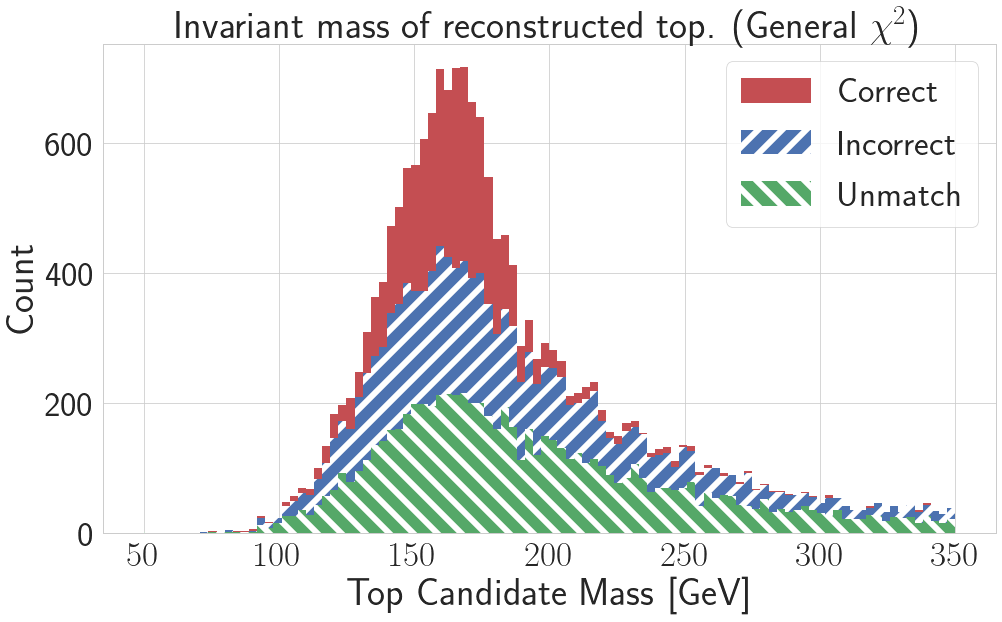

In [9]:
mkfunc = lambda x, pos: '%1.0f M' % (x * 1e-6) if x >= 1e6 else '$%1.0f$K' % (x * 1e-3) if x >= 1e3 else '%1.0f' % x
mkformatter = ticker.FuncFormatter(mkfunc)
sb.set(context='paper', style='whitegrid', font_scale=4.0)
makedirs("./figures/", exist_ok=True)
rcParams['text.usetex'] = True
rcParams['hatch.linewidth'] = 6

fig, ax = plt.subplots(figsize=(16,9))
plt.hist(np.concatenate((general_correct_top_inv, general_incorrect_top_inv, general_unmatch_top_inv)), range=(50, 350), bins=100, color='r', label='Correct', linewidth=0.00, antialiased=True)
plt.hist(np.concatenate((general_unmatch_top_inv, general_incorrect_top_inv)), color='b', range=(50, 350), bins=100, label='Incorrect', linewidth=0.00, antialiased=True, hatch='/')
plt.hist(general_unmatch_top_inv, color='g', range=(50, 350), bins=100, label='Unmatch', linewidth=0.00, antialiased=True, hatch='\\')
plt.legend(loc='upper right')
plt.title("Invariant mass of reconstructed top. (General $\chi^{2}$)")
plt.xlabel('Top Candidate Mass [GeV]')
plt.ylabel('Count')
ax.yaxis.set_major_formatter(mkformatter)


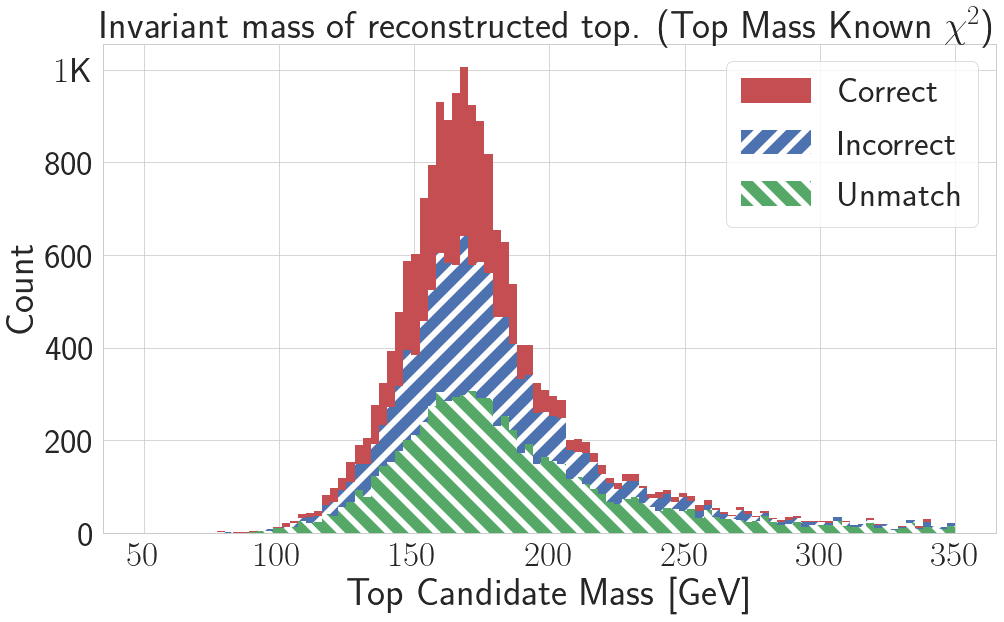

In [10]:
fig, ax = plt.subplots(figsize=(16,9))
plt.hist(np.concatenate((mtop_correct_top_inv, mtop_incorrect_top_inv, mtop_unmatch_top_inv)), color='r', range=(50, 350), bins=100, label='Correct', linewidth=0.00, antialiased=True)
plt.hist(np.concatenate((mtop_unmatch_top_inv, mtop_incorrect_top_inv)), color='b', range=(50, 350), bins=100, label='Incorrect', linewidth=0.00, antialiased=True, hatch='/')
plt.hist(mtop_unmatch_top_inv, range=(50, 350), color='g', bins=100, label='Unmatch', linewidth=0.00, antialiased=True, hatch='\\')
plt.legend(loc='upper right')
plt.title("Invariant mass of reconstructed top. (Top Mass Known $\chi^{2}$)")
plt.xlabel('Top Candidate Mass [GeV]')
plt.ylabel('Count')
ax.yaxis.set_major_formatter(mkformatter)


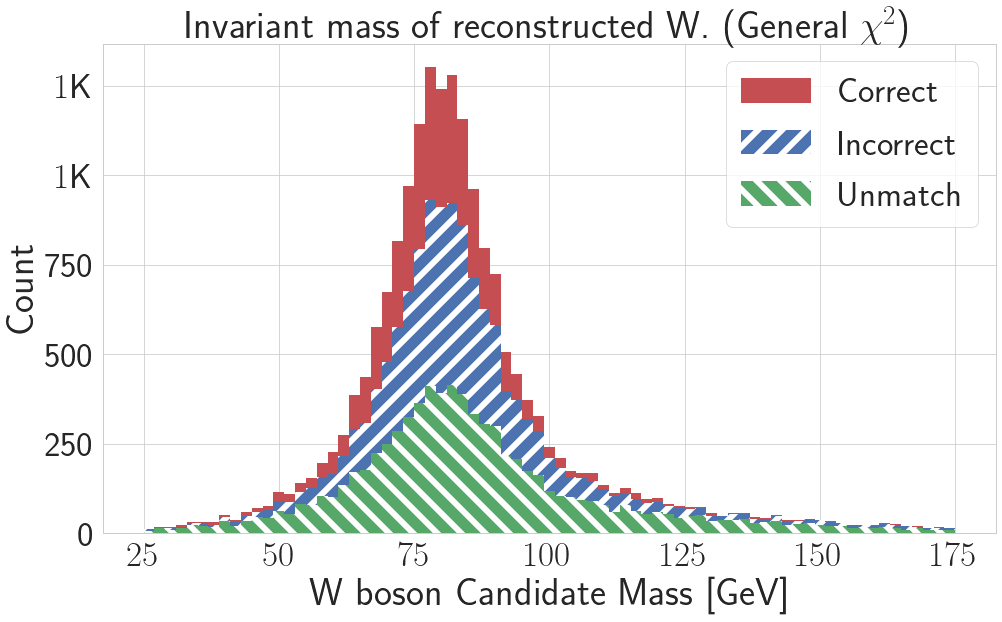

In [11]:
fig, ax = plt.subplots(figsize=(16,9))
plt.hist(np.concatenate((general_correct_W_inv, general_incorrect_W_inv, general_unmatch_W_inv)), range=(25, 175), bins=75, color='r', label='Correct', linewidth=0.00, antialiased=True)
plt.hist(np.concatenate((general_unmatch_W_inv, general_incorrect_W_inv)), color='b', range=(25, 175), bins=75, label='Incorrect', linewidth=0.00, antialiased=True, hatch='/')
plt.hist(general_unmatch_W_inv, color='g', range=(25, 175), bins=75, label='Unmatch', linewidth=0.00, antialiased=True, hatch='\\')
plt.legend(loc='upper right')
plt.title("Invariant mass of reconstructed W. (General $\chi^{2}$)")
plt.xlabel('W boson Candidate Mass [GeV]')
plt.ylabel('Count')
ax.yaxis.set_major_formatter(mkformatter)

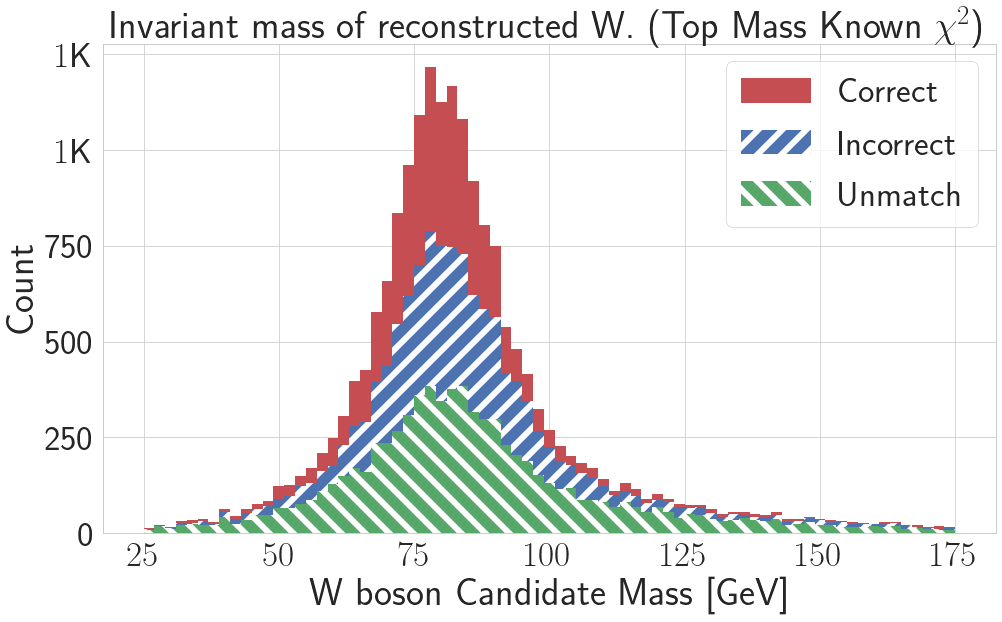

In [12]:
fig, ax = plt.subplots(figsize=(16,9))
plt.hist(np.concatenate((mtop_correct_W_inv, mtop_incorrect_W_inv, mtop_unmatch_W_inv)), color='r', range=(25, 175), bins=75, label='Correct', linewidth=0.00, antialiased=True)
plt.hist(np.concatenate((mtop_unmatch_W_inv, mtop_incorrect_W_inv)), color='b', range=(25, 175), bins=75, label='Incorrect', linewidth=0.00, antialiased=True, hatch='/')
plt.hist(mtop_unmatch_W_inv, range=(25, 175), color='g', bins=75, label='Unmatch', linewidth=0.00, antialiased=True, hatch='\\')
plt.legend(loc='upper right')
plt.title("Invariant mass of reconstructed W. (Top Mass Known $\chi^{2}$)")
plt.xlabel('W boson Candidate Mass [GeV]')
plt.ylabel('Count')
ax.yaxis.set_major_formatter(mkformatter)


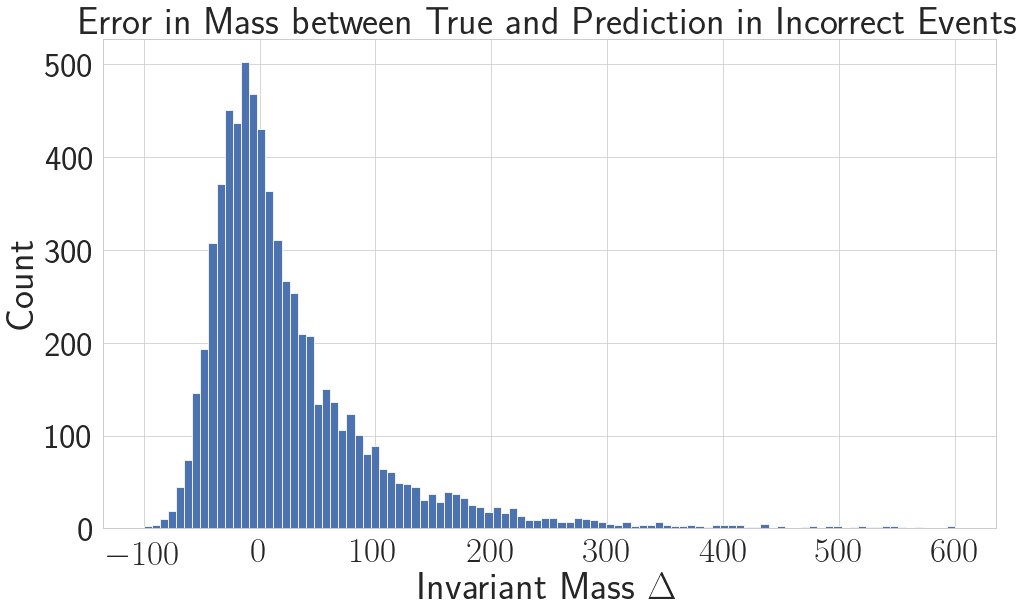

In [13]:
error_top = np.subtract(general_incorrect_top_inv, 173)
fig, ax = plt.subplots(figsize=(16,9))
plt.hist(error_top, bins=100, range=(-100,600))
plt.xlabel("Invariant Mass $\Delta$")
plt.ylabel("Count")
plt.title("Error in Mass between True and Prediction in Incorrect Events")
ax.yaxis.set_major_formatter(mkformatter)


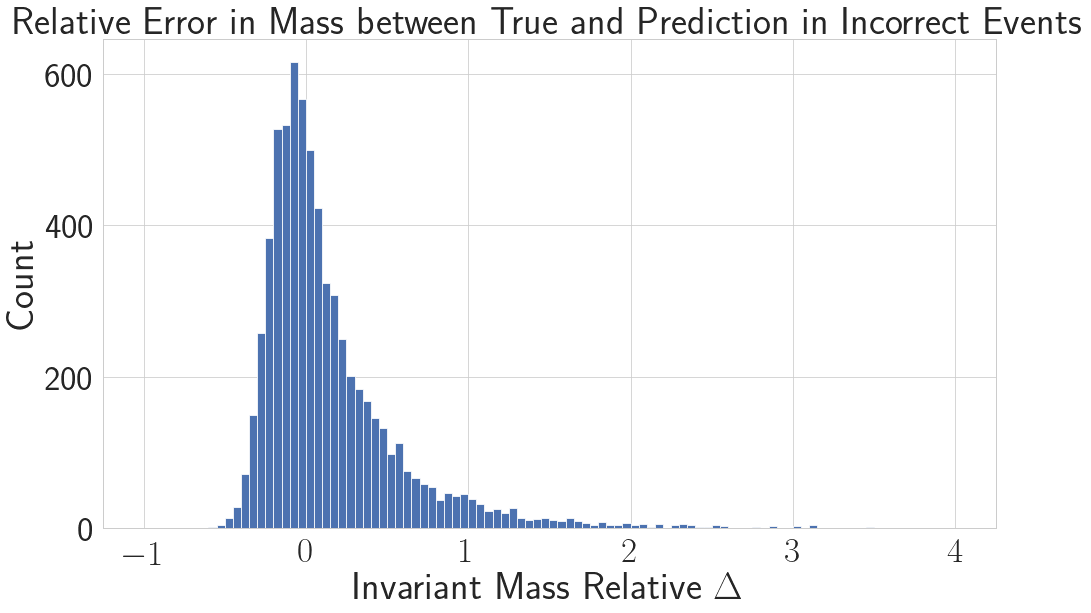

In [14]:
rel_error_top = np.subtract(general_incorrect_top_inv, 173)/173
fig, ax = plt.subplots(figsize=(16,9))
plt.hist(rel_error_top, bins=100, range=(-1,4))
plt.xlabel("Invariant Mass Relative $\Delta$")
plt.ylabel("Count")
plt.title("Relative Error in Mass between True and Prediction in Incorrect Events")
ax.yaxis.set_major_formatter(mkformatter)


In [15]:
num_jet = np.zeros(len(jet_pt))
for i in range(len(jet_pt)):
    num_jet[i] = len(jet_pt[i])

chi2_six_jet = np.where(num_jet == 6)
chi2_seven_jet = np.where(num_jet == 7)
chi2_eight_jet = np.where(num_jet >= 8)

twin_top_six_jet = np.intersect1d(chi2_n_match_2_idx, chi2_six_jet)
single_top_six_jet = np.intersect1d(chi2_n_match_1_idx, chi2_six_jet)

twin_top_seven_jet = np.intersect1d(chi2_n_match_2_idx, chi2_seven_jet)
single_top_seven_jet = np.intersect1d(chi2_n_match_1_idx, chi2_seven_jet)

twin_top_eight_jet = np.intersect1d(chi2_n_match_2_idx, chi2_eight_jet)
single_top_eight_jet = np.intersect1d(chi2_n_match_1_idx, chi2_eight_jet)

##################################################################################################################
# 6 jet limitation
twin_top_general_chi2_predict_six_jet = general_chi2_predict[twin_top_six_jet]
single_top_general_chi2_predict_six_jet = general_chi2_predict[single_top_six_jet]

twin_top_mtop_chi2_predict_six_jet = mtop_chi2_predict[twin_top_six_jet]
single_top_mtop_chi2_predict_six_jet = mtop_chi2_predict[single_top_six_jet]

twin_top_truth_matching_six_jet = truth_matching[twin_top_six_jet]
single_top_truth_matching_six_jet = truth_matching[single_top_six_jet] 
##################################################################################################################

##################################################################################################################
# 7 jet limitation
twin_top_general_chi2_predict_seven_jet = general_chi2_predict[twin_top_seven_jet]
single_top_general_chi2_predict_seven_jet = general_chi2_predict[single_top_seven_jet]

twin_top_mtop_chi2_predict_seven_jet = mtop_chi2_predict[twin_top_seven_jet]
single_top_mtop_chi2_predict_seven_jet = mtop_chi2_predict[single_top_seven_jet]

twin_top_truth_matching_seven_jet = truth_matching[twin_top_seven_jet]
single_top_truth_matching_seven_jet = truth_matching[single_top_seven_jet] 
##################################################################################################################

##################################################################################################################
# 8 jet limitation
twin_top_general_chi2_predict_eight_jet = general_chi2_predict[twin_top_eight_jet]
single_top_general_chi2_predict_eight_jet = general_chi2_predict[single_top_eight_jet]

twin_top_mtop_chi2_predict_eight_jet = mtop_chi2_predict[twin_top_eight_jet]
single_top_mtop_chi2_predict_eight_jet = mtop_chi2_predict[single_top_eight_jet]

twin_top_truth_matching_eight_jet = truth_matching[twin_top_eight_jet]
single_top_truth_matching_eight_jet = truth_matching[single_top_eight_jet] 
##################################################################################################################


In [16]:
# Compute purity for all case(un-filtered, both match, partial match) with limiting number of jet == 6.
general_chi2_case_six_jet, general_chi2_correct_right_six_jet, general_chi2_correct_left_six_jet = compute(general_chi2_predict[chi2_six_jet], truth_matching[chi2_six_jet])
general_chi2_cas_2_six_jet, general_chi2_correct_right_2_six_jet, general_chi2_correct_left_2_six_jet = compute(twin_top_general_chi2_predict_six_jet, twin_top_truth_matching_six_jet)
general_chi2_case_1_six_jet, general_chi2_correct_right_1_six_jet, general_chi2_correct_left_1_six_jet = compute(single_top_general_chi2_predict_six_jet, single_top_truth_matching_six_jet)

mtop_chi2_case_six_jet, mtop_chi2_correct_right_six_jet, mtop_chi2_correct_left_six_jet = compute(mtop_chi2_predict[chi2_six_jet], truth_matching[chi2_six_jet])
mtop_chi2_cas_2_six_jet, mtop_chi2_correct_right_2_six_jet, mtop_chi2_correct_left_2_six_jet = compute(twin_top_mtop_chi2_predict_six_jet, twin_top_truth_matching_six_jet)
mtop_chi2_case_1_six_jet, mtop_chi2_correct_right_1_six_jet, mtop_chi2_correct_left_1_six_jet = compute(single_top_mtop_chi2_predict_six_jet, single_top_truth_matching_six_jet)

100%|██████████| 2108/2108 [00:00<00:00, 57211.96it/s]


In [17]:
print(f'6 jets event purity and top purity.')

general_chi2_event_purity_six_jet = np.sum(general_chi2_case_six_jet==1)/( np.sum(general_chi2_case_six_jet==1) + np.sum(general_chi2_case_six_jet==2) + np.sum(general_chi2_case_six_jet==3))
general_chi2_two_top_purity_six_jet = ( np.sum(general_chi2_correct_right_2_six_jet ==1) + np.sum(general_chi2_correct_left_2_six_jet==1)  )/( np.sum(general_chi2_correct_right_2_six_jet ==1) + np.sum(general_chi2_correct_left_2_six_jet==1) + np.sum(general_chi2_correct_right_2_six_jet ==0) + np.sum(general_chi2_correct_left_2_six_jet==0) )
general_chi2_single_top_purity_six_jet = ( np.sum(general_chi2_correct_right_1_six_jet == 1) + np.sum(general_chi2_correct_left_1_six_jet == 1)  )/(  len(general_chi2_correct_right_1_six_jet) )

print(f'Event putiry (no filter, general chi2)                         : {general_chi2_event_purity_six_jet:.3f}')
print(f'Two top putiry (both match, general chi2)                      : {general_chi2_two_top_purity_six_jet:.3f}')
print(f'Single top putiry (partial match, general chi2)                : {general_chi2_single_top_purity_six_jet:.3f}')

print("-"*80)

mtop_chi2_event_purity_six_jet = np.sum(mtop_chi2_case_six_jet==1)/( np.sum(mtop_chi2_case_six_jet==1) + np.sum(mtop_chi2_case_six_jet==2) + np.sum(mtop_chi2_case_six_jet==3))
mtop_chi2_two_top_purity_six_jet = ( np.sum(mtop_chi2_correct_right_2_six_jet ==1) + np.sum(mtop_chi2_correct_left_2_six_jet==1)  )/( np.sum(mtop_chi2_correct_right_2_six_jet ==1) + np.sum(mtop_chi2_correct_left_2_six_jet==1) + np.sum(mtop_chi2_correct_right_2_six_jet ==0) + np.sum(mtop_chi2_correct_left_2_six_jet==0) )
mtop_chi2_single_top_purity_six_jet = ( np.sum(mtop_chi2_correct_right_1_six_jet==1) + np.sum(mtop_chi2_correct_left_1_six_jet==1)  )/( len(mtop_chi2_correct_right_1_six_jet ) )
print(f'Event putiry (no filter, top mass based chi2)                  : {mtop_chi2_event_purity_six_jet:.3f}')
print(f'Two top putiry (both match, top mass based chi2)               : {mtop_chi2_two_top_purity_six_jet:.3f}')
print(f'Single top putiry (partial match, top mass based chi2)         : {mtop_chi2_single_top_purity_six_jet:.3f}')

6 jets event purity and top purity.
Event putiry (no filter, general chi2)                         : 0.566
Two top putiry (both match, general chi2)                      : 0.601
Single top putiry (partial match, general chi2)                : 0.240
--------------------------------------------------------------------------------
Event putiry (no filter, top mass based chi2)                  : 0.649
Two top putiry (both match, top mass based chi2)               : 0.677
Single top putiry (partial match, top mass based chi2)         : 0.303


In [18]:
# Compute purity for all case(un-filtered, both match, partial match) with limiting number of jets == 7 
general_chi2_case_seven_jet, general_chi2_correct_right_seven_jet, general_chi2_correct_left_seven_jet = compute(general_chi2_predict[chi2_seven_jet], truth_matching[chi2_seven_jet])
general_chi2_cas_2_seven_jet, general_chi2_correct_right_2_seven_jet, general_chi2_correct_left_2_seven_jet = compute(twin_top_general_chi2_predict_seven_jet, twin_top_truth_matching_seven_jet)
general_chi2_case_1_seven_jet, general_chi2_correct_right_1_seven_jet, general_chi2_correct_left_1_seven_jet = compute(single_top_general_chi2_predict_seven_jet, single_top_truth_matching_seven_jet)

mtop_chi2_case_seven_jet, mtop_chi2_correct_right_seven_jet, mtop_chi2_correct_left_seven_jet = compute(mtop_chi2_predict[chi2_seven_jet], truth_matching[chi2_seven_jet])
mtop_chi2_cas_2_seven_jet, mtop_chi2_correct_right_2_seven_jet, mtop_chi2_correct_left_2_seven_jet = compute(twin_top_mtop_chi2_predict_seven_jet, twin_top_truth_matching_seven_jet)
mtop_chi2_case_1_seven_jet, mtop_chi2_correct_right_1_seven_jet, mtop_chi2_correct_left_1_seven_jet = compute(single_top_mtop_chi2_predict_seven_jet, single_top_truth_matching_seven_jet)

100%|██████████| 2183/2183 [00:00<00:00, 57677.72it/s]


In [19]:
print(f'7 jets event purity and top purity.')

general_chi2_event_purity_seven_jet = np.sum(general_chi2_case_seven_jet==1)/( np.sum(general_chi2_case_seven_jet==1) + np.sum(general_chi2_case_seven_jet==2) + np.sum(general_chi2_case_seven_jet==3))
general_chi2_two_top_purity_seven_jet = ( np.sum(general_chi2_correct_right_2_seven_jet ==1) + np.sum(general_chi2_correct_left_2_seven_jet==1)  )/( np.sum(general_chi2_correct_right_2_seven_jet ==1) + np.sum(general_chi2_correct_left_2_seven_jet==1) + np.sum(general_chi2_correct_right_2_seven_jet ==0) + np.sum(general_chi2_correct_left_2_seven_jet==0) )
general_chi2_single_top_purity_seven_jet = ( np.sum(general_chi2_correct_right_1_seven_jet == 1) + np.sum(general_chi2_correct_left_1_seven_jet == 1)  )/(  len(general_chi2_correct_right_1_seven_jet) )

print(f'Event putiry (no filter, general chi2)                         : {general_chi2_event_purity_seven_jet:.3f}')
print(f'Two top putiry (both match, general chi2)                      : {general_chi2_two_top_purity_seven_jet:.3f}')
print(f'Single top putiry (partial match, general chi2)                : {general_chi2_single_top_purity_seven_jet:.3f}')

print("-"*80)

mtop_chi2_event_purity_seven_jet = np.sum(mtop_chi2_case_seven_jet==1)/( np.sum(mtop_chi2_case_seven_jet==1) + np.sum(mtop_chi2_case_seven_jet==2) + np.sum(mtop_chi2_case_seven_jet==3))
mtop_chi2_two_top_purity_seven_jet = ( np.sum(mtop_chi2_correct_right_2_seven_jet ==1) + np.sum(mtop_chi2_correct_left_2_seven_jet==1)  )/( np.sum(mtop_chi2_correct_right_2_seven_jet ==1) + np.sum(mtop_chi2_correct_left_2_seven_jet==1) + np.sum(mtop_chi2_correct_right_2_seven_jet ==0) + np.sum(mtop_chi2_correct_left_2_seven_jet==0) )
mtop_chi2_single_top_purity_seven_jet = ( np.sum(mtop_chi2_correct_right_1_seven_jet==1) + np.sum(mtop_chi2_correct_left_1_seven_jet==1)  )/( len(mtop_chi2_correct_right_1_seven_jet ) )
print(f'Event putiry (no filter, top mass based chi2)                  : {mtop_chi2_event_purity_seven_jet:.3f}')
print(f'Two top putiry (both match, top mass based chi2)               : {mtop_chi2_two_top_purity_seven_jet:.3f}')
print(f'Single top putiry (partial match, top mass based chi2)         : {mtop_chi2_single_top_purity_seven_jet:.3f}')

7 jets event purity and top purity.
Event putiry (no filter, general chi2)                         : 0.401
Two top putiry (both match, general chi2)                      : 0.494
Single top putiry (partial match, general chi2)                : 0.251
--------------------------------------------------------------------------------
Event putiry (no filter, top mass based chi2)                  : 0.445
Two top putiry (both match, top mass based chi2)               : 0.545
Single top putiry (partial match, top mass based chi2)         : 0.322


In [20]:
# Compute purity for all case(un-filtered, both match, partial match) with limiting number of jet >=8
general_chi2_case_eight_jet, general_chi2_correct_right_eight_jet, general_chi2_correct_left_eight_jet = compute(general_chi2_predict[chi2_eight_jet], truth_matching[chi2_eight_jet])
general_chi2_cas_2_eight_jet, general_chi2_correct_right_2_eight_jet, general_chi2_correct_left_2_eight_jet = compute(twin_top_general_chi2_predict_eight_jet, twin_top_truth_matching_eight_jet)
general_chi2_case_1_eight_jet, general_chi2_correct_right_1_eight_jet, general_chi2_correct_left_1_eight_jet = compute(single_top_general_chi2_predict_eight_jet, single_top_truth_matching_eight_jet)

mtop_chi2_case_eight_jet, mtop_chi2_correct_right_eight_jet, mtop_chi2_correct_left_eight_jet = compute(mtop_chi2_predict[chi2_eight_jet], truth_matching[chi2_eight_jet])
mtop_chi2_cas_2_eight_jet, mtop_chi2_correct_right_2_eight_jet, mtop_chi2_correct_left_2_eight_jet = compute(twin_top_mtop_chi2_predict_eight_jet, twin_top_truth_matching_eight_jet)
mtop_chi2_case_1_eight_jet, mtop_chi2_correct_right_1_eight_jet, mtop_chi2_correct_left_1_eight_jet = compute(single_top_mtop_chi2_predict_eight_jet, single_top_truth_matching_eight_jet)

100%|██████████| 2150/2150 [00:00<00:00, 56856.68it/s]


In [21]:
print(f'Over 8 jets event purity and top purity.')

general_chi2_event_purity_eight_jet = np.sum(general_chi2_case_eight_jet==1)/( np.sum(general_chi2_case_eight_jet==1) + np.sum(general_chi2_case_eight_jet==2) + np.sum(general_chi2_case_eight_jet==3))
general_chi2_two_top_purity_eight_jet = ( np.sum(general_chi2_correct_right_2_eight_jet ==1) + np.sum(general_chi2_correct_left_2_eight_jet==1)  )/( np.sum(general_chi2_correct_right_2_eight_jet ==1) + np.sum(general_chi2_correct_left_2_eight_jet==1) + np.sum(general_chi2_correct_right_2_eight_jet ==0) + np.sum(general_chi2_correct_left_2_eight_jet==0) )
general_chi2_single_top_purity_eight_jet = ( np.sum(general_chi2_correct_right_1_eight_jet == 1) + np.sum(general_chi2_correct_left_1_eight_jet == 1)  )/(  len(general_chi2_correct_right_1_eight_jet) )

print(f'Event putiry (no filter, general chi2)                         : {general_chi2_event_purity_eight_jet:.3f}')
print(f'Two top putiry (both match, general chi2)                      : {general_chi2_two_top_purity_eight_jet:.3f}')
print(f'Single top putiry (partial match, general chi2)                : {general_chi2_single_top_purity_eight_jet:.3f}')

print("-"*80)

mtop_chi2_event_purity_eight_jet = np.sum(mtop_chi2_case_eight_jet==1)/( np.sum(mtop_chi2_case_eight_jet==1) + np.sum(mtop_chi2_case_eight_jet==2) + np.sum(mtop_chi2_case_eight_jet==3))
mtop_chi2_two_top_purity_eight_jet = ( np.sum(mtop_chi2_correct_right_2_eight_jet ==1) + np.sum(mtop_chi2_correct_left_2_eight_jet==1)  )/( np.sum(mtop_chi2_correct_right_2_eight_jet ==1) + np.sum(mtop_chi2_correct_left_2_eight_jet==1) + np.sum(mtop_chi2_correct_right_2_eight_jet ==0) + np.sum(mtop_chi2_correct_left_2_eight_jet==0) )
mtop_chi2_single_top_purity_eight_jet = ( np.sum(mtop_chi2_correct_right_1_eight_jet==1) + np.sum(mtop_chi2_correct_left_1_eight_jet==1)  )/( len(mtop_chi2_correct_right_1_eight_jet ) )
print(f'Event putiry (no filter, top mass based chi2)                  : {mtop_chi2_event_purity_eight_jet:.3f}')
print(f'Two top putiry (both match, top mass based chi2)               : {mtop_chi2_two_top_purity_eight_jet:.3f}')
print(f'Single top putiry (partial match, top mass based chi2)         : {mtop_chi2_single_top_purity_eight_jet:.3f}')

Over 8 jets event purity and top purity.
Event putiry (no filter, general chi2)                         : 0.233
Two top putiry (both match, general chi2)                      : 0.363
Single top putiry (partial match, general chi2)                : 0.200
--------------------------------------------------------------------------------
Event putiry (no filter, top mass based chi2)                  : 0.285
Two top putiry (both match, top mass based chi2)               : 0.431
Single top putiry (partial match, top mass based chi2)         : 0.284


In [22]:
print(f'No filterd event purity and top purity.')

general_chi2_event_purity = np.sum(general_chi2_case==1)/( np.sum(general_chi2_case==1) + np.sum(general_chi2_case==2) + np.sum(general_chi2_case==3))
general_chi2_two_top_purity = ( np.sum(general_chi2_correct_right_2 ==1) + np.sum(general_chi2_correct_left_2==1)  )/( np.sum(general_chi2_correct_right_2 ==1) + np.sum(general_chi2_correct_left_2==1) + np.sum(general_chi2_correct_right_2 ==0) + np.sum(general_chi2_correct_left_2==0) )
general_chi2_single_top_purity = ( np.sum(general_chi2_correct_right_1 == 1) + np.sum(general_chi2_correct_left_1 == 1)  )/(  len(general_chi2_correct_right_1) )

print(f'Event putiry (no filter, general chi2)                              : {general_chi2_event_purity:.3f}')
print(f'Two top putiry (both match, general chi2)                           : {general_chi2_two_top_purity:.3f}')
print(f'Single top putiry (partial match, general chi2)                     : {general_chi2_single_top_purity:.3f}')

print("-"*80)

mtop_chi2_event_purity = np.sum(mtop_chi2_case==1)/( np.sum(mtop_chi2_case==1) + np.sum(mtop_chi2_case==2) + np.sum(mtop_chi2_case==3))
mtop_chi2_two_top_purity = ( np.sum(mtop_chi2_correct_right_2 ==1) + np.sum(mtop_chi2_correct_left_2==1)  )/( np.sum(mtop_chi2_correct_right_2 ==1) + np.sum(mtop_chi2_correct_left_2==1) + np.sum(mtop_chi2_correct_right_2 ==0) + np.sum(mtop_chi2_correct_left_2==0) )
mtop_chi2_single_top_purity = ( np.sum(mtop_chi2_correct_right_1==1) + np.sum(mtop_chi2_correct_left_1==1)  )/( len(mtop_chi2_correct_right_1) )
print(f'Event putiry (no filter, top mass based chi2)                       : {mtop_chi2_event_purity:.3f}')
print(f'Two top putiry (both matched, top mass based chi2)                  : {mtop_chi2_two_top_purity:.3f}')
print(f'Single top putiry (partial matched, top mass based chi2)            : {mtop_chi2_single_top_purity:.3f}')

No filterd event purity and top purity.
Event putiry (no filter, general chi2)                              : 0.359
Two top putiry (both match, general chi2)                           : 0.456
Single top putiry (partial match, general chi2)                     : 0.230
--------------------------------------------------------------------------------
Event putiry (no filter, top mass based chi2)                       : 0.415
Two top putiry (both matched, top mass based chi2)                  : 0.521
Single top putiry (partial matched, top mass based chi2)            : 0.303
